## Two 2-D covariance matrices

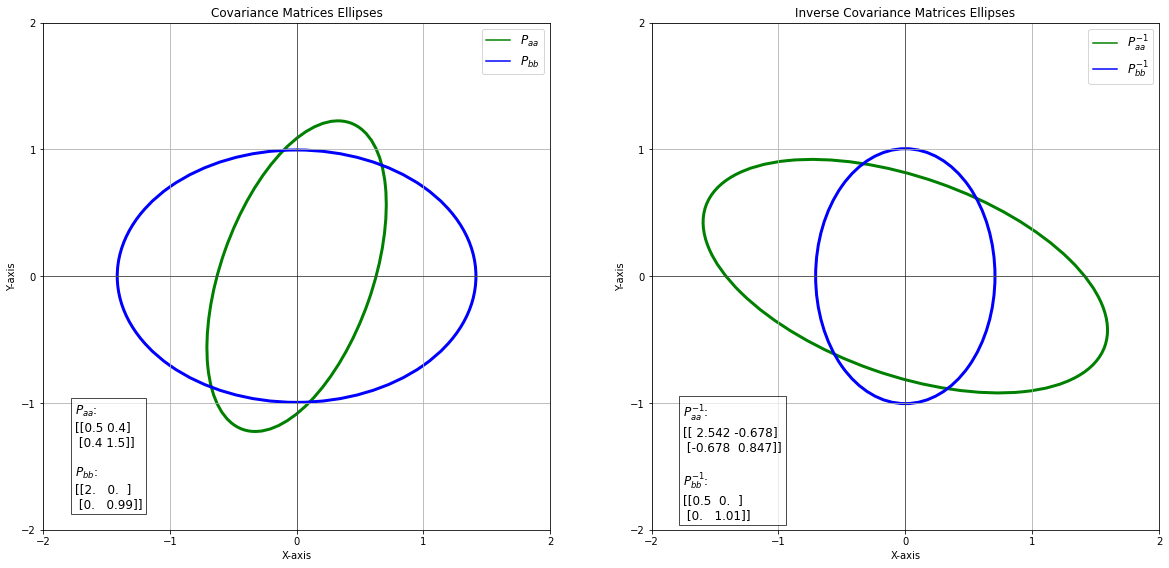

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

# Define function to draw covariance and inverse covariance ellipses
def draw_ellipse(matrix, axis, color="black", linestyle="-", linewidth=2):
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eig(matrix)

    # Find the angle of rotation
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # Create the ellipse
    ellipse = Ellipse(
        xy=(0, 0),
        width=2 * np.sqrt(vals[0]),
        height=2 * np.sqrt(vals[1]),
        angle=angle,
        edgecolor=color,
        linestyle=linestyle,
        linewidth=linewidth,
        facecolor='none'
    )

    # Add the ellipse to the plot
    axis.add_patch(ellipse)

    return ellipse

# Define array to store error covariance matrices to plot together at the very end
final_fused_cov_matrices = { "matrices": [], "legend_handles": [], "colors": [] }
final_fused_inv_cov_matrices = { "matrices": [], "legend_handles": [], "colors": [] }

# Define the covariance matrices
cov_matrix1 = np.array([[0.5, 0.4],
                        [0.4, 1.5]])

cov_matrix2 = np.array([[2, 0],
                        [0, 0.99]])

inv_cov_matrix1 = np.linalg.inv(cov_matrix1)
inv_cov_matrix2 = np.linalg.inv(cov_matrix2)

cov_matrices = [cov_matrix1, cov_matrix2]
inv_cov_matrices = [inv_cov_matrix1, inv_cov_matrix2]

# Create a figure and axis
fig1, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Set the background color to dark
fig1.set_facecolor('white')
ax1.set_facecolor('white')

colors = ['g', 'b']  # Colors for the two ellipses
cov_labels = ['$P_{aa}$', '$P_{bb}$']
inv_cov_labels = ['$P^{-1}_{aa}$', '$P^{-1}_{bb}$']

for i, (cov, inv_cov) in enumerate(zip(cov_matrices, inv_cov_matrices)):
    draw_ellipse(cov, ax1, colors[i], linewidth=3)
    draw_ellipse(inv_cov, ax2, colors[i], linewidth=3)

# Add the covariance matrix text next to the ellipse
ax1.text(-1.75, -1, f'{cov_labels[0]}:\n{cov_matrices[0]}\n\n{cov_labels[1]}:\n{cov_matrices[1]}',
        fontsize='large', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.7})
ax2.text(-1.75, -1, f'{inv_cov_labels[0]}:\n{np.round(inv_cov_matrices[0],3)}\n\n{inv_cov_labels[1]}:\n{np.round(inv_cov_matrices[1],3)}',
        fontsize='large', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.7})

# Add axes
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)

# Set axis labels
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")

# Set tick marks
ax1.set_xticks(np.arange(-2, 3))
ax1.set_yticks(np.arange(-2, 3))
ax2.set_xticks(np.arange(-2, 3))
ax2.set_yticks(np.arange(-2, 3))

# Customize the legend with larger font size and lines as markers
cov_mat_leg_handles = [mlines.Line2D([], [], color=color, markersize=10, label=label) for color, label in zip(colors, cov_labels)]
ax1.legend(handles=cov_mat_leg_handles, loc='upper right', fontsize='large')
inv_cov_mat_leg_handles = [mlines.Line2D([], [], color=color, markersize=10, label=label) for color, label in zip(colors, inv_cov_labels)]
ax2.legend(handles=inv_cov_mat_leg_handles, loc='upper right', fontsize='large')

# Set aspect ratio to be equal
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

# Show the plot
ax1.set_title("Covariance Matrices Ellipses")
ax1.grid()
ax2.set_title("Inverse Covariance Matrices Ellipses")
ax2.grid()


## Optimal fusion with information on the correlation matrix

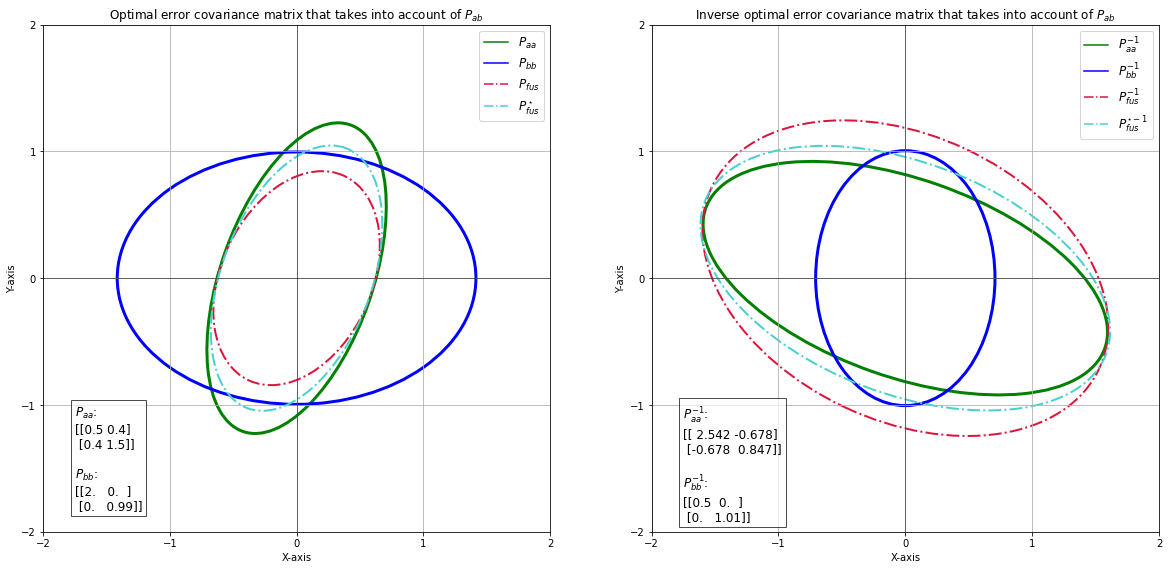

In [2]:
from scipy.optimize import minimize

# Define a correlation matrix
Gamma = np.array([[2.3, 0.01],
                        [0.01, 1.3]])
cross_covar_matrix_12 = np.matmul(cov_matrix1, np.matmul(np.linalg.inv(Gamma), cov_matrix2))

# Define cost function
def trace_of_P(W, corr: True):
    # Compute the trace of the matrix and define your cost function here
    weight_1 = W[:4].reshape(2, 2)
    weight_2 = W[4:].reshape(2, 2)

    if corr:
        P = np.matmul(weight_1, np.matmul(cov_matrix1, weight_1.T)) + \
            np.matmul(weight_1, np.matmul(cross_covar_matrix_12, weight_2.T)) + \
            np.matmul(weight_2, np.matmul(cross_covar_matrix_12.T, weight_1.T)) + \
            np.matmul(weight_2, np.matmul(cov_matrix2, weight_2.T))
    else:
        P = np.matmul(weight_1, np.matmul(cov_matrix1, weight_1.T)) + \
            np.matmul(weight_2, np.matmul(cov_matrix2, weight_2.T))

    return np.trace(P)

def eigenvalues_of_P(W):
    # Compute the eigenvalues of the P matrix
    weight_1 = W[:4].reshape(2, 2)
    weight_2 = W[4:].reshape(2, 2)
    
    P = np.matmul(weight_1, np.matmul(cov_matrix1, weight_1.T)) + \
        np.matmul(weight_1, np.matmul(cross_covar_matrix_12, weight_2.T)) + \
        np.matmul(weight_2, np.matmul(cross_covar_matrix_12.T, weight_1.T)) + \
        np.matmul(weight_2, np.matmul(cov_matrix2, weight_2.T))

    return np.linalg.eigvals(P)

# Define the initial guess for W1 and W2
initial_guess = (np.random.rand(2,2), np.random.rand(2,2))
initial_guess = np.concatenate((initial_guess[0].ravel(), initial_guess[1].ravel()))

# Constraint to ensure that W1 + W2 is the identity matrix
identity_constraint = {'type': 'eq', 'fun': lambda W: (W[:4].reshape(2, 2) + W[4:].reshape(2, 2)).ravel() - np.eye(2).ravel()}

# Constraint to ensure that the trace is positive (small positive constant = 1e-6)
eigenval_constraint = {'type': 'ineq', 'fun': lambda W: eigenvalues_of_P(W).ravel() - np.array([1e-6, 1e-6]).ravel()}

# Minimize the trace
correct_result = minimize(trace_of_P, initial_guess, args=True, constraints=[eigenval_constraint,identity_constraint], method='SLSQP')

# With correlation
W1 = correct_result.x[:4].reshape(2, 2)
W2 = correct_result.x[4:].reshape(2, 2)

# Compute optimal ellipse
cov_matrix3 = np.matmul(W1, np.matmul(cov_matrix1, W1.T)) + \
              np.matmul(W1, np.matmul(cross_covar_matrix_12, W2.T)) + \
              np.matmul(W2, np.matmul(cross_covar_matrix_12.T, W1.T)) + \
              np.matmul(W2, np.matmul(cov_matrix2, W2.T))

# Draw the ellipses
fused_cov_matrices = [cov_matrix3, np.linalg.inv(inv_cov_matrix1 + inv_cov_matrix2 - np.linalg.inv(Gamma))]
fused_colors = ["crimson", "mediumturquoise"]
fused_labels = ["$P_{fus}$", "$P^\star_{fus}$"]
fused_inv_labels = ["$P^{-1}_{fus}$", "$P^{\star -1}_{fus}$"]
fused_ellipse_patches = []
fused_inv_ellipse_patches = []

for i, mat in enumerate(fused_cov_matrices):
    fused_ellipse_patches.append(draw_ellipse(mat, ax1, fused_colors[i], "-."))
    fused_inv_ellipse_patches.append(draw_ellipse(np.linalg.inv(mat), ax2, fused_colors[i], "-."))

txt1 = "Optimal error covariance matrix that takes into account of $P_{ab}$"

ax1.set_title(txt1)
new_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_labels[i]) for i in range(len(fused_cov_matrices))]
ax1.legend(handles=cov_mat_leg_handles + new_cov_mat_leg_handle, loc='upper right', fontsize='large')

txt2 = "Inverse optimal error covariance matrix that takes into account of $P_{ab}$"

ax2.set_title(txt2)
new_inv_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_inv_labels[i]) for i in range(len(fused_cov_matrices))]
ax2.legend(handles=inv_cov_mat_leg_handles + new_inv_cov_mat_leg_handle, loc='upper right', fontsize='large')

# Store the matrices
# final_fused_cov_matrices["matrices"].extend(fused_cov_matrices)
# final_fused_cov_matrices["legend_handles"].extend(new_cov_mat_leg_handle)
# final_fused_cov_matrices["colors"].extend(fused_colors)
final_fused_cov_matrices["matrices"].append(fused_cov_matrices[1])
final_fused_cov_matrices["legend_handles"].append(new_cov_mat_leg_handle[1])
final_fused_cov_matrices["colors"].append(fused_colors[1])

# final_fused_inv_cov_matrices["matrices"].extend([np.linalg.inv(m) for m in fused_cov_matrices])
# final_fused_inv_cov_matrices["legend_handles"].extend(new_inv_cov_mat_leg_handle)
# final_fused_inv_cov_matrices["colors"].extend(fused_colors)
final_fused_inv_cov_matrices["matrices"].append(np.linalg.inv(fused_cov_matrices[1]))
final_fused_inv_cov_matrices["legend_handles"].append(new_inv_cov_mat_leg_handle[1])
final_fused_inv_cov_matrices["colors"].append(fused_colors[1])

fig1

## Covariance intersection with a correlation matrix

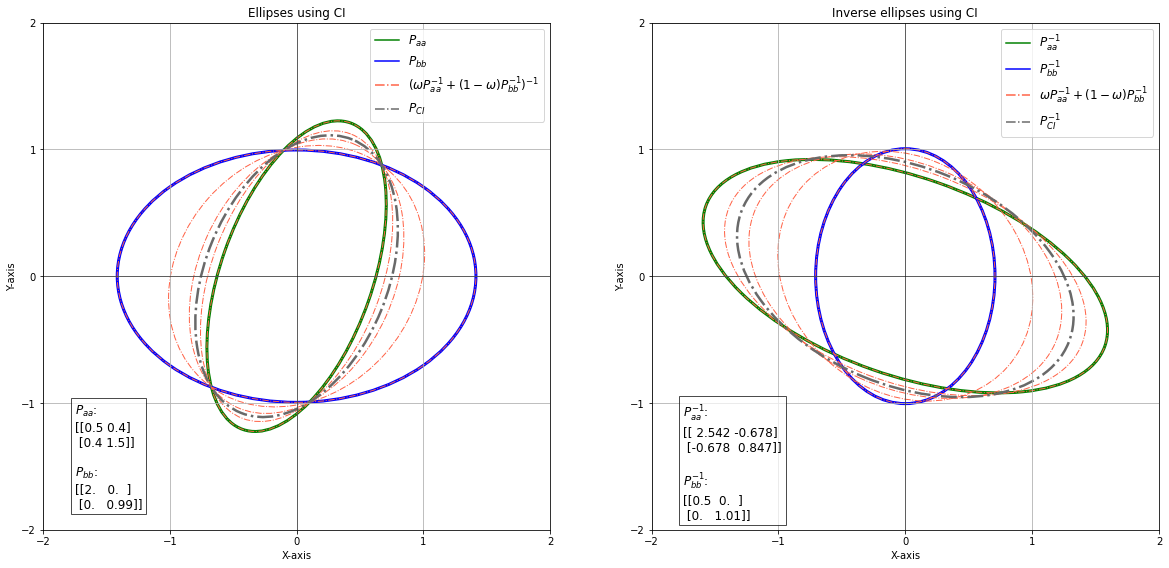

In [3]:
enclosure_ellipse = []
enclosure_ellipse_inv = []
[p.remove() for p in fused_ellipse_patches] # remove the previous fused ellipses
[p.remove() for p in fused_inv_ellipse_patches] # remove the previous fused ellipses
fused_ellipse_patches = []
fused_inv_ellipse_patches = []

def trace_of_P_CI(W):
    return np.trace(np.linalg.inv(W[0] * inv_cov_matrix1 + W[1] * inv_cov_matrix2))

def eigenvalues_of_P_CI(w):
    return np.linalg.eigvals(np.linalg.inv(w*inv_cov_matrix1 + (1-w)*inv_cov_matrix2))

# Compute CI based error covariance matrix
initial_guess = np.random.rand(2)

# Constraint to ensure that W1 + W2 is the identity matrix
identity_constraint = {'type': 'eq', 'fun': lambda W: np.sum(W) - 1}

psd_constraint = {'type': "ineq", "fun": lambda W: trace_of_P_CI(W) - 1e-6}

# Constraint to ensure that the trace is positive (small positive constant = 1e-6)
eigenval_constraint_CI = {'type': 'ineq', 'fun': lambda W: eigenvalues_of_P_CI(W).ravel() - np.array([1e-6, 1e-6]).ravel()}

# Minimize the trace
result_CI = minimize(trace_of_P_CI, initial_guess, constraints=[psd_constraint, identity_constraint], method='SLSQP')

# Plot different combinations of lambda = omega*A + (1-omega)*B
fused_colors = ["tomato", "dimgray"]
fused_labels = ["$(\omega P_{aa}^{-1} + (1 - \omega)P_{bb}^{-1})^{-1}$", "$P_{CI}$"]
fused_inv_labels = ["$\omega P_{aa}^{-1} + (1 - \omega)P_{bb}^{-1}$", "$P_{CI}^{-1}$"]

for omega in np.append(np.linspace(0, 1, 5, endpoint=True), result_CI.x[0]):

    if omega == result_CI.x[0]:
        col = fused_colors[-1]
        lw = 2.5
    else:
        col = "tomato"
        lw = 1

    lamb = np.linalg.inv(omega*inv_cov_matrix1 + (1-omega)*inv_cov_matrix2)

    enclosure_ellipse.append(draw_ellipse(lamb, ax1, col, "-.", lw))
    enclosure_ellipse_inv.append(draw_ellipse(np.linalg.inv(lamb), ax2, col, "-.", lw))

txt1 = "Ellipses using CI"
ax1.set_title(txt1)
new_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_labels[i]) for i in range(2)]
ax1.legend(handles=cov_mat_leg_handles+new_cov_mat_leg_handle, loc='upper right', fontsize='large')

txt2 = "Inverse ellipses using CI"
ax2.set_title(txt2)
new_inv_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_inv_labels[i]) for i in range(2)]
ax2.legend(handles=inv_cov_mat_leg_handles + new_inv_cov_mat_leg_handle, loc='upper right', fontsize='large')

# Store the matrices
final_fused_cov_matrices["matrices"].append(lamb)
final_fused_cov_matrices["legend_handles"].append(new_cov_mat_leg_handle[1])
final_fused_cov_matrices["colors"].append(fused_colors[1])

final_fused_inv_cov_matrices["matrices"].append(np.linalg.inv(lamb))
final_fused_inv_cov_matrices["legend_handles"].append(new_inv_cov_mat_leg_handle[1])
final_fused_inv_cov_matrices["colors"].append(fused_colors[1])

fig1

## Ellipsoidal intersection with a correlation matrix

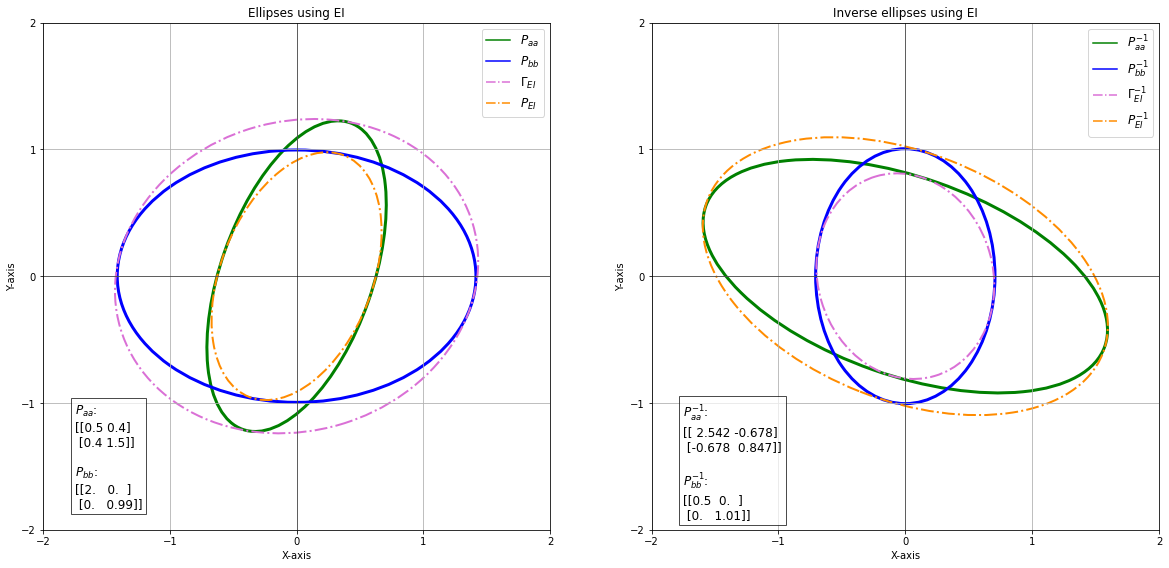

In [4]:
[p.remove() for p in enclosure_ellipse]
[p.remove() for p in enclosure_ellipse_inv]
fused_ellipse_patches = []
fused_inv_ellipse_patches = []

# Compute using ellipsoidal intersection method
def ellipsoidal_intersection(P_a, P_b):

    # Perform eigendecomposition for P_a
    eigenval1, eigenvec1 = np.linalg.eig(P_a)
    D1 = np.diag(eigenval1)
    D1_inv = np.linalg.inv(D1)
    S1 = eigenvec1

    # Perform eigendecomposition for P_b
    D1_sqrt = np.diag([np.sqrt(D1[i,i]) for i in range(D1.shape[0])])
    D1_inv_sqrt = np.diag([np.sqrt(D1_inv[i,i]) for i in range(D1.shape[0])])
    eigenval2, eigenvec2 = np.linalg.eig(D1_inv_sqrt @ np.linalg.inv(S1) @ P_b @ S1 @ D1_inv_sqrt)
    D2 = np.diag(eigenval2)
    S2 = eigenvec2

    # Compute transformation matrix
    T = S1 @ D1_sqrt @ S2
    D_bar = np.diag([np.max( (D2[i,i], 1) ) for i in range(T.shape[0])])

    # Return the ellipse (matrix) that tightly encloses both the P_a and P_b ellipses
    return S1 @ D1_sqrt @ S2  @ D_bar @ np.linalg.inv(S2) @ D1_sqrt @ np.linalg.inv(S1)

Gamma_ei = ellipsoidal_intersection(cov_matrix1, cov_matrix2)
error_covar_ei = np.linalg.inv(np.linalg.inv(cov_matrix1) + np.linalg.inv(cov_matrix2) - np.linalg.inv(Gamma_ei))

# Draw ellipses
fused_cov_matrices = [Gamma_ei, error_covar_ei]
fused_colors = ["orchid", "darkorange"]
fused_labels = ["$\Gamma_{EI}$", "$P_{EI}$"]
fused_inv_labels = ["$\Gamma^{-1}_{EI}$", "$P^{-1}_{EI}$"]

for i, mat in enumerate(fused_cov_matrices):
    fused_ellipse_patches.append(draw_ellipse(mat, ax1, fused_colors[i], "-."))
    fused_inv_ellipse_patches.append(draw_ellipse(np.linalg.inv(mat), ax2, fused_colors[i], "-."))

txt1 = "Ellipses using EI"

ax1.set_title(txt1)
new_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_labels[i]) for i in range(len(fused_cov_matrices))]
ax1.legend(handles=cov_mat_leg_handles + new_cov_mat_leg_handle, loc='upper right', fontsize='large')

txt2 = "Inverse ellipses using EI"

ax2.set_title(txt2)
new_inv_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_inv_labels[i]) for i in range(len(fused_cov_matrices))]
ax2.legend(handles=inv_cov_mat_leg_handles + new_inv_cov_mat_leg_handle, loc='upper right', fontsize='large')

# Store the matrices
final_fused_cov_matrices["matrices"].append(fused_cov_matrices[1])
final_fused_cov_matrices["legend_handles"].append(new_cov_mat_leg_handle[1])
final_fused_cov_matrices["colors"].append(fused_colors[1])

final_fused_inv_cov_matrices["matrices"].append(np.linalg.inv(fused_cov_matrices[1]))
final_fused_inv_cov_matrices["legend_handles"].append(new_inv_cov_mat_leg_handle[1])
final_fused_inv_cov_matrices["colors"].append(fused_colors[1])

fig1

## Inverse covariance intersection with correlation matrix

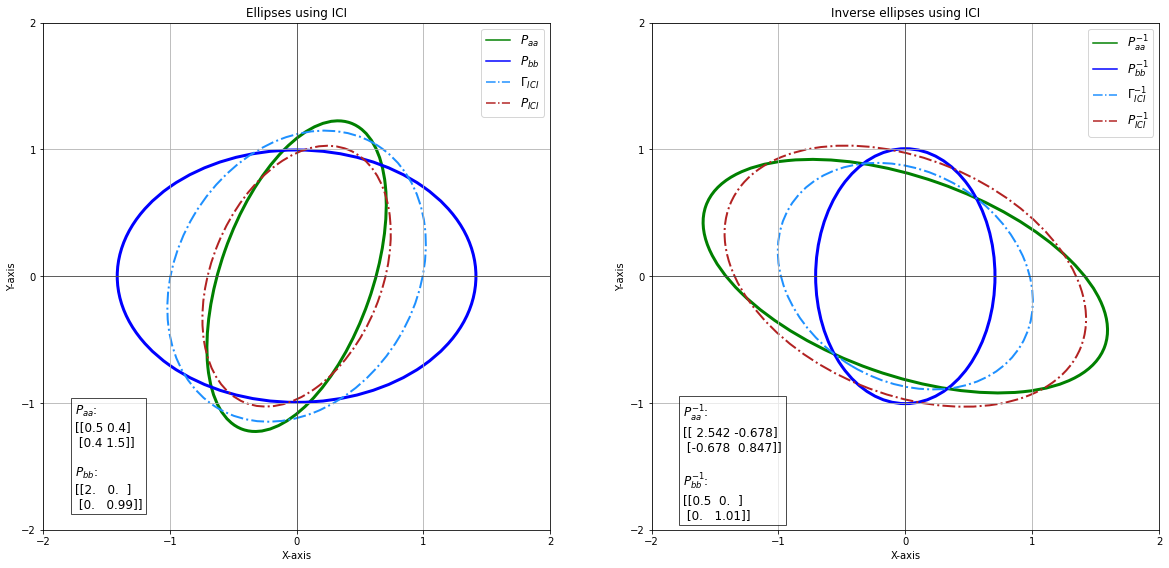

In [5]:
[p.remove() for p in fused_ellipse_patches] # remove the previous fused ellipses
[p.remove() for p in fused_inv_ellipse_patches] # remove the previous fused ellipses
fused_ellipse_patches = []
fused_inv_ellipse_patches = []

def trace_of_P_ICI(W):
    return np.trace( np.linalg.inv(inv_cov_matrix1 + inv_cov_matrix2 - np.linalg.inv(W[0]*cov_matrix1 + W[1]*cov_matrix2)) )

# Compute CI based error covariance matrix
initial_guess = np.random.rand(2)

# Constraint to ensure that W1 + W2 is the identity matrix
identity_constraint = {'type': 'eq', 'fun': lambda W: np.sum(W) - 1}

psd_constraint = {'type': "ineq", "fun": lambda W: trace_of_P_ICI(W) - 1e-6}

# Minimize the trace
result_ICI = minimize(trace_of_P_ICI, initial_guess, constraints=[psd_constraint, identity_constraint], method='SLSQP')
Gamma_ICI = result_ICI.x[0]*cov_matrix1 + result_ICI.x[1]*cov_matrix2
error_covar_ICI = np.linalg.inv(inv_cov_matrix1 + inv_cov_matrix2 - np.linalg.inv(Gamma_ICI))

# Draw ellipses
fused_cov_matrices = [Gamma_ICI, error_covar_ICI]
fused_colors = ["dodgerblue", "firebrick"]
fused_labels = ["$\Gamma_{ICI}$", "$P_{ICI}$"]
fused_inv_labels = ["$\Gamma_{ICI}^{-1}$", "$P^{-1}_{ICI}$"]

for i, mat in enumerate(fused_cov_matrices):
    fused_ellipse_patches.append(draw_ellipse(mat, ax1, fused_colors[i], "-."))
    fused_inv_ellipse_patches.append(draw_ellipse(np.linalg.inv(mat), ax2, fused_colors[i], "-."))

txt1 = "Ellipses using ICI"

ax1.set_title(txt1)
new_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_labels[i]) for i in range(len(fused_cov_matrices))]
ax1.legend(handles=cov_mat_leg_handles + new_cov_mat_leg_handle, loc='upper right', fontsize='large')

txt2 = "Inverse ellipses using ICI"

ax2.set_title(txt2)
new_inv_cov_mat_leg_handle = [mlines.Line2D([], [], color=fused_colors[i], linestyle="-.", markersize=10, label=fused_inv_labels[i]) for i in range(len(fused_cov_matrices))]
ax2.legend(handles=inv_cov_mat_leg_handles + new_inv_cov_mat_leg_handle, loc='upper right', fontsize='large')

# Store the matrices
final_fused_cov_matrices["matrices"].append(fused_cov_matrices[1])
final_fused_cov_matrices["legend_handles"].append(new_cov_mat_leg_handle[1])
final_fused_cov_matrices["colors"].append(fused_colors[1])

final_fused_inv_cov_matrices["matrices"].append(np.linalg.inv(fused_cov_matrices[1]))
final_fused_inv_cov_matrices["legend_handles"].append(new_inv_cov_mat_leg_handle[1])
final_fused_inv_cov_matrices["colors"].append(fused_colors[1])

fig1

## Comparing all fusion methods

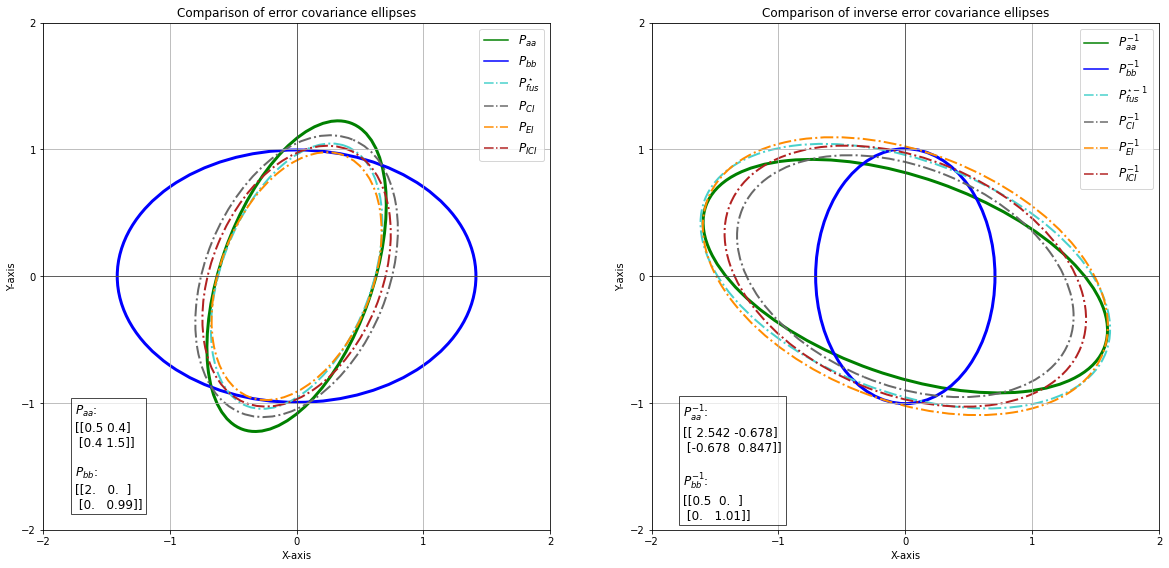

In [6]:
[p.remove() for p in fused_ellipse_patches]
[p.remove() for p in fused_inv_ellipse_patches]

for i in range(len(final_fused_cov_matrices["matrices"])):
    draw_ellipse(final_fused_cov_matrices["matrices"][i], ax1, final_fused_cov_matrices["colors"][i], "-.")
    draw_ellipse(final_fused_inv_cov_matrices["matrices"][i], ax2, final_fused_inv_cov_matrices["colors"][i], "-.")

txt1 = "Comparison of error covariance ellipses"

ax1.set_title(txt1)
ax1.legend(handles=cov_mat_leg_handles + final_fused_cov_matrices["legend_handles"], loc='upper right', fontsize='large')

txt2 = "Comparison of inverse error covariance ellipses"

ax2.set_title(txt2)
ax2.legend(handles=inv_cov_mat_leg_handles + final_fused_inv_cov_matrices["legend_handles"], loc='upper right', fontsize='large')

fig1